In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from preprocess import any_null_col, add_coordinates
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.model_selection import GroupShuffleSplit




pd.options.display.max_columns = 999
random_state = 39
import warnings
warnings.filterwarnings('ignore')

In [4]:
n = 90000
# df = pd.read_csv('../../CSGO/mm_master_demos.csv')[:
df = pd.read_csv('../data/mm_master_demos.csv')

df = df.sample(frac=0.1, random_state=random_state)
df = df.drop(['Unnamed: 0', 'file'], axis=1).reset_index(drop=True)
## rank = 0 means the player does not play competitive games
df = df[df['att_rank'] != 0]
df.head()

,map,date,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,is_bomb_planted,bomb_site,hitbox,wp,wp_type,award,winner_team,winner_side,att_id,att_rank,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,de_mirage,09/28/2017 8:47:23 PM,12,74000,1156.781,Team 1,Team 1,CounterTerrorist,CounterTerrorist,14,0,False,NaN,RightLeg,Deagle,Pistol,300,Team 1,CounterTerrorist,76561198129930965,9,76561198178182678,8,-1529.5890,-2167.3310,-1383.3080,-2279.8580,ECO,30300,7600,8.0
1,de_inferno,09/28/2017 8:56:01 PM,26,177767,2778.144,Team 1,Team 2,Terrorist,CounterTerrorist,27,3,False,NaN,Chest,AK47,Rifle,300,Team 2,CounterTerrorist,76561198049586514,18,76561198156184266,16,69.5624,1087.1110,102.3935,1552.7860,NORMAL,29850,26300,16.0
2,de_inferno,09/20/2017 10:30:05 AM,20,141194,2206.730,Team 1,Team 2,Terrorist,CounterTerrorist,74,15,False,NaN,Head,AK47,Rifle,300,Team 1,Terrorist,76561198004222916,13,76561198073770861,12,1468.1990,151.8160,2543.7320,-84.7408,NORMAL,18300,20500,13.0
3,de_mirage,09/28/2017 9:40:01 PM,21,142943,2234.041,Team 2,Team 1,CounterTerrorist,Terrorist,14,1,False,NaN,Stomach,XM1014,Heavy,900,Team 2,CounterTerrorist,76561198068609350,9,76561198249015896,8,-1416.3320,263.4925,-1833.6930,295.7267,NORMAL,23150,16350,9.0
4,de_mirage,09/28/2017 9:17:15 PM,20,115935,1811.975,Team 1,Team 2,Terrorist,CounterTerrorist,26,1,False,NaN,Stomach,Tec9,Pistol,300,Team 2,CounterTerrorist,76561198262727977,15,76561198305235533,16,-1661.8430,827.7089,-2377.0640,710.0730,ECO,30100,4300,15.0


In [5]:
pd.read_csv('../../CSGO/mm_master_demos.csv').shape

(955466, 33)

In [6]:
sns.reset_orig()

In [7]:
df.head()

,map,date,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,is_bomb_planted,bomb_site,hitbox,wp,wp_type,award,winner_team,winner_side,att_id,att_rank,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,de_mirage,09/28/2017 8:47:23 PM,12,74000,1156.781,Team 1,Team 1,CounterTerrorist,CounterTerrorist,14,0,False,NaN,RightLeg,Deagle,Pistol,300,Team 1,CounterTerrorist,76561198129930965,9,76561198178182678,8,-1529.5890,-2167.3310,-1383.3080,-2279.8580,ECO,30300,7600,8.0
1,de_inferno,09/28/2017 8:56:01 PM,26,177767,2778.144,Team 1,Team 2,Terrorist,CounterTerrorist,27,3,False,NaN,Chest,AK47,Rifle,300,Team 2,CounterTerrorist,76561198049586514,18,76561198156184266,16,69.5624,1087.1110,102.3935,1552.7860,NORMAL,29850,26300,16.0
2,de_inferno,09/20/2017 10:30:05 AM,20,141194,2206.730,Team 1,Team 2,Terrorist,CounterTerrorist,74,15,False,NaN,Head,AK47,Rifle,300,Team 1,Terrorist,76561198004222916,13,76561198073770861,12,1468.1990,151.8160,2543.7320,-84.7408,NORMAL,18300,20500,13.0
3,de_mirage,09/28/2017 9:40:01 PM,21,142943,2234.041,Team 2,Team 1,CounterTerrorist,Terrorist,14,1,False,NaN,Stomach,XM1014,Heavy,900,Team 2,CounterTerrorist,76561198068609350,9,76561198249015896,8,-1416.3320,263.4925,-1833.6930,295.7267,NORMAL,23150,16350,9.0
4,de_mirage,09/28/2017 9:17:15 PM,20,115935,1811.975,Team 1,Team 2,Terrorist,CounterTerrorist,26,1,False,NaN,Stomach,Tec9,Pistol,300,Team 2,CounterTerrorist,76561198262727977,15,76561198305235533,16,-1661.8430,827.7089,-2377.0640,710.0730,ECO,30100,4300,15.0


In [8]:
### Checks if df has null values
if_null = any_null_col(df)

Columns containing null values: ['bomb_site'] with null ratios: [0.847]


In [9]:
### many rows have null values for 'bomb_site' because is the bomb is not planted, i.e. is_bomb_planted = False, there is no bomb_site
# verification:
np.mean(df['is_bomb_planted'] == False) == np.mean(df['bomb_site'].isnull())

True

#### Target Variable: att_rank
- att_rank is an ordinal variable indicating players' ranks from 1 to 18
- att_rank = 0 is dropped from dataframe since we are only interested in players who has a rank
- att_rank: the rank for the attacker

There is only 0.014% of players at rank 1, i.e. only 13 out of 93391 players.


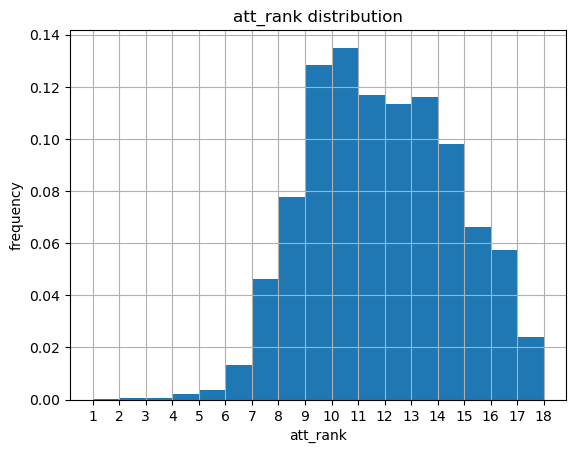

In [10]:
### target variable
# distribution
# it is difficult to get very good, yet it's also very hard to stay very bad 
target = 'att_rank'
df[target].hist(bins=df[target].nunique()-1, density=True)
plt.xticks(range(1, 19))
rank_1_n = np.sum(df[target] == 1)
rank_1_percent = np.round(np.mean(df[target] == 1) * 100, 3)
plt.title('att_rank distribution')
plt.xlabel('att_rank')
plt.ylabel('frequency')
# sns.set(rc={'axes.facecolor':'#accea1', 'figure.facecolor':'#accea1'}, font_scale=1.5)
# sns.set_color_codes(palette='muted')


print('There is only {}% of players at rank 1, i.e. only {} out of {} players.'.format(rank_1_percent, rank_1_n, df.shape[0]))

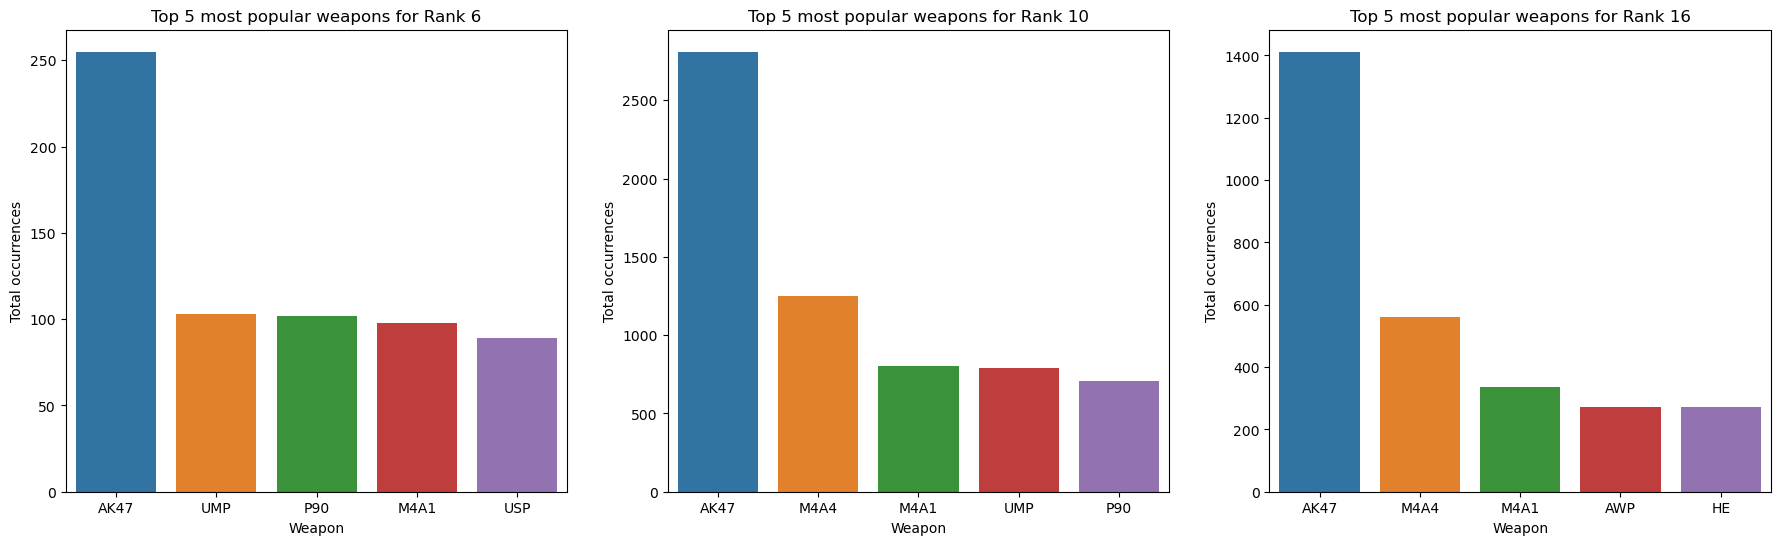

In [11]:
wp_ranks = [6, 10, 16]
n_top_wp = 5
fig, ax = plt.subplots(1, len(wp_ranks), figsize=(22, 6))
for i in range(len(wp_ranks)):
    top_5_weaps = df[df['att_rank'] == wp_ranks[i]]['wp'].value_counts().head(n_top_wp)

    sns.barplot(ax=ax[i], x=top_5_weaps.index, y=top_5_weaps.values)
    ax[i].set_xlabel('Weapon')
    ax[i].set_ylabel('Total occurrences')
    ax[i].set_title('Top {} most popular weapons for Rank {}'.format(n_top_wp, wp_ranks[i]))


# sns.despine()



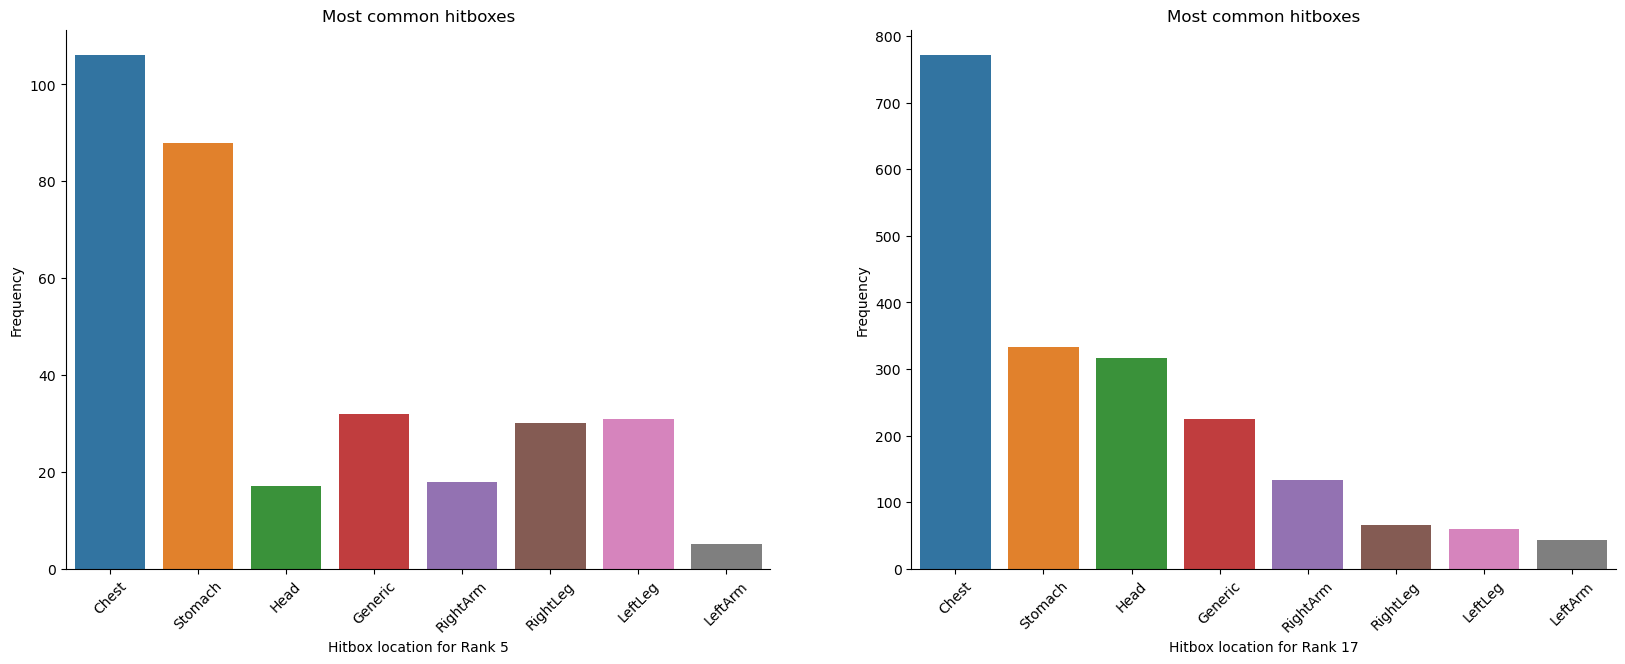

In [12]:
hit_box_ranks = [5, 17]
fig, ax = plt.subplots(1, len(hit_box_ranks), figsize=(20, 7))

# sns.set(font_scale=10)


for i in range(len(hit_box_ranks)):
    
    g = sns.countplot(df[df['att_rank'] == hit_box_ranks[i]]['hitbox'], ax=ax[i], order=df['hitbox'].value_counts().index)
    # g = sns.countplot(df[df['att_rank'] == hit_box_ranks[i]]['hitbox'], ax=ax[i])

    # g = sns.histplot(df[df['att_rank'] == hit_box_ranks[i]]['hitbox'], ax=ax[i], stat='density')

    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    ax[i].set_xlabel('Hitbox location for Rank {}'.format(hit_box_ranks[i]))
    ax[i].set_ylabel('Frequency')
    ax[i].set_title('Most common hitboxes')
sns.despine()

# sns.set(rc={'axes.facecolor':'#accea1', 'figure.facecolor':'#accea1'}, font_scale=4)
# sns.set_color_codes(palette='muted')




## TODO: hitbox for different weapons!!!!

In [13]:
map_data = pd.read_csv('../../CSGO/map_data.csv', index_col=0)
map_data.loc['de_overpass'] = {'StartX': -4820, 'StartY': -3591, 'EndX': 503, 'EndY': 1740, 'ResX': 1024, 'ResY': 1024}
map_data.loc['de_nuke'] = {'StartX': -3082, 'StartY': -4464, 'EndX': 3516, 'EndY': 2180, 'ResX': 1024, 'ResY': 1024}
df_ = pd.read_csv('../../CSGO/mm_master_demos.csv')
df_ = df_.drop(['Unnamed: 0', 'file'], axis=1).reset_index(drop=True)
## rank = 0 means the player does not play competitive games
df_ = df_[df_['att_rank'] != 0]

add_coordinates(df_, map_data)

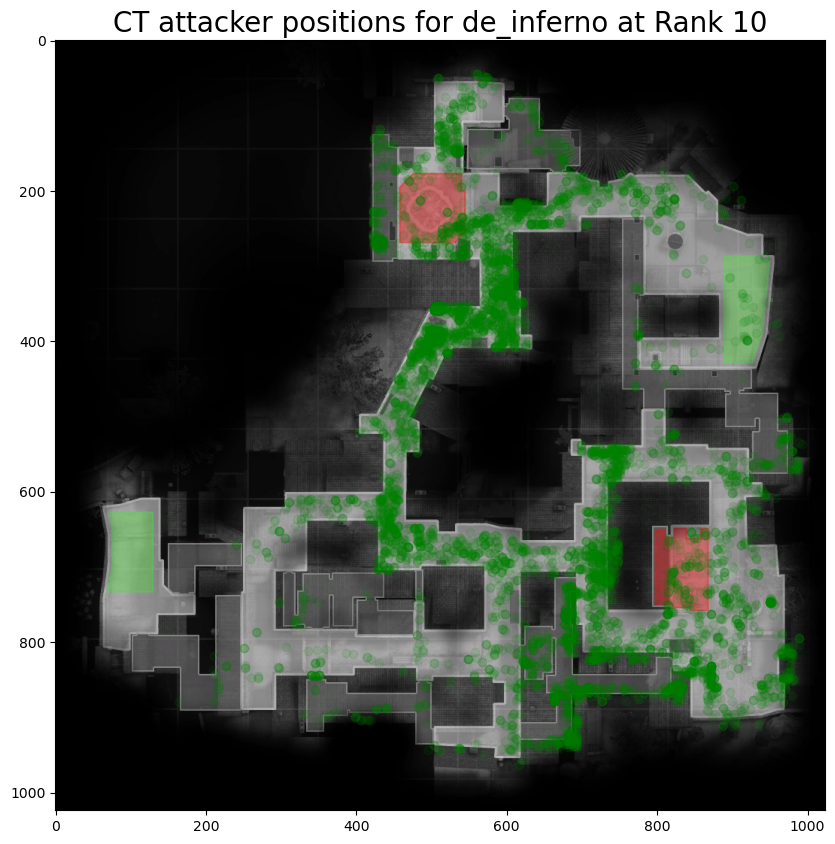

In [14]:
map_name = 'de_inferno'
map_rank = 10
CT = 'CounterTerrorist'
T = 'Terrorist'

map_data = df_.loc[(df_['map'] == map_name) & (df_['att_rank'] == map_rank) & (df_['att_side'] == CT)]
# map_data = df.loc[df['map'] == map_name]
# map_data = df_.loc[(df_['map'] == map_name) & (df_['att_rank'] == map_rank)]



# Plot attack positions.
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread(f'../images/{map_name}.png'))
plt.scatter(map_data['AttackPosX'], map_data['AttackPosY'], alpha=0.1, c='green')
plt.title(f'CT attacker positions for {map_name} at Rank {map_rank}', fontsize=20)
# sns.set_style("whitegrid", {'axes.grid' : False})

# sns.set_color_codes(palette='muted')
# sns.set(rc={'axes.facecolor':'#accea1', 'figure.facecolor':'#accea1'}, font_scale=4, style='white')

plt.show()

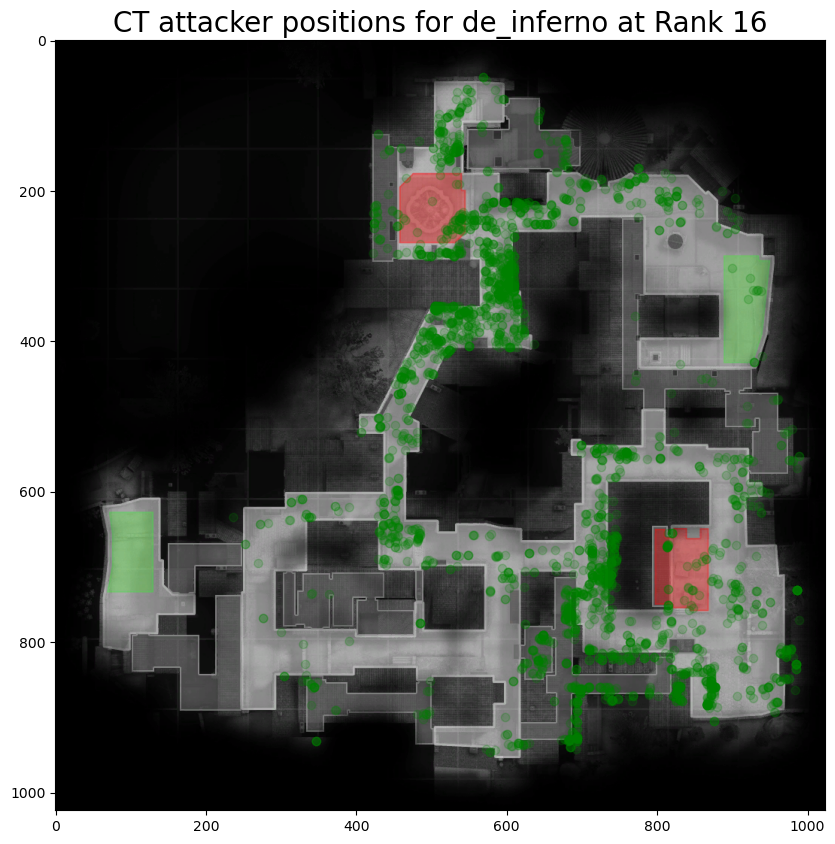

In [15]:
map_name = 'de_inferno'
map_rank = 16
CT = 'CounterTerrorist'
T = 'Terrorist'

map_data = df_.loc[(df_['map'] == map_name) & (df_['att_rank'] == map_rank) & (df_['att_side'] == CT)]
# map_data = df.loc[df['map'] == map_name]
# map_data = df_.loc[(df_['map'] == map_name) & (df_['att_rank'] == map_rank)]



# Plot attack positions.
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread(f'../images/{map_name}.png'))
plt.scatter(map_data['AttackPosX'], map_data['AttackPosY'], alpha=0.2, c='green')
plt.title(f'CT attacker positions for {map_name} at Rank {map_rank}', fontsize=20)
# sns.set_color_codes(palette='muted')
# sns.set(rc={'axes.facecolor':'#accea1', 'figure.facecolor':'#accea1'}, font_scale=4, style='white')
plt.show()

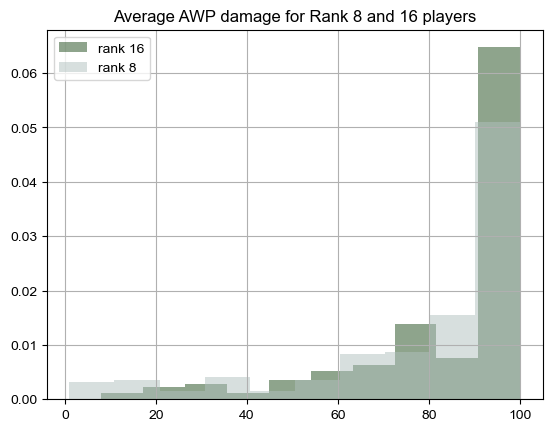

In [16]:
hist_data = df[df['wp'] == 'AWP'].groupby('att_id').agg({'att_rank':np.mean, 'hp_dmg':np.mean})
hist_data[hist_data['att_rank'] == 16]['hp_dmg'].hist(alpha=0.5, label='rank 16', density=True, color="#1f4a1b")
hist_data[hist_data['att_rank'] == 8]['hp_dmg'].hist(alpha=0.5, label='rank 8', density=True, color='#b1c0bf')
plt.legend()
plt.title('Average AWP damage for Rank 8 and 16 players')
sns.set(rc={'axes.facecolor':'#accea1', 'figure.facecolor':'#accea1'}, font_scale=1, style='white')


In [17]:
to_drop = ['date', 'att_team', 'round', 'tick', 'vic_team', 'vic_side', 'bomb_site', 'award', 'winner_team', 'winner_side', 'vic_id', 'avg_match_rank']
dmg = df.drop(to_drop, axis=1)

gss = GroupShuffleSplit(n_splits=1, test_size=0.02, random_state=42)
other_i, data_i = next(gss.split(dmg, groups=dmg['att_id']))
other = dmg.iloc[other_i]
dmg = dmg.iloc[data_i]

In [18]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold
# import svc
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
# import make_scorer
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
# import ridge
from sklearn.linear_model import Ridge
# import xgboost
import xgboost as xgb

In [19]:

ordinal_ftrs = ['vic_rank']
ordinal_cats = list(range(1, 19))
onehot_ftrs = ['map', 'att_side', 'is_bomb_planted', 'hitbox', 'wp_type', 'round_type', 'wp']
minmax_ftrs = ['seconds', 'hp_dmg', 'arm_dmg']
std_ftrs = ['att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y', 'ct_eq_val', 't_eq_val']

preprocessor = ColumnTransformer(
    transformers=[
        # ('ord', OrdinalEncoder(categories=ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)
    ]
)

clf = Pipeline(steps=[('preprocessor', preprocessor)])

# Regression Models

In [20]:

X = dmg.drop(['att_rank', 'att_id'], axis=1)
y = dmg['att_rank']
groups = dmg['att_id']
random_states = np.arange(5) * 42


def ML_pipeline_groups_GridSearchCV(X, y, groups, random_states, model, n_folds, param_grid):
    models = []
    scores = []
    X_tests = []
    y_tests = []

    for random_state in random_states:
        gss = GroupShuffleSplit(n_splits=1, test_size=0.4, random_state=random_state)
        other_i, test_i = next(gss.split(X, y, groups))
        X_other, y_other, groups_other = X.iloc[other_i], y.iloc[other_i], groups.iloc[other_i]
        X_test, y_test, groups_test = X.iloc[test_i], y.iloc[test_i], groups.iloc[test_i]

        X_other_prep = clf.fit_transform(X_other)
        X_test_prep = clf.transform(X_test)
        
        group_kfold = GroupKFold(n_splits=4)

        pipe = Pipeline(steps=[('model', model)])
        grid = GridSearchCV(pipe, param_grid, cv=group_kfold, scoring="neg_mean_squared_error", n_jobs=-1)
        grid.fit(X_other_prep, y_other, groups=groups_other)

        models.append(grid.best_estimator_)
        scores.append(grid.score(X_test_prep, y_test))
        X_tests.append(X_test_prep)
        y_tests.append(y_test)



    return models, scores, X_tests, y_tests

In [21]:
#### baseline model
y_pred = [y.mean()] * len(y)
baseline_mse = mean_squared_error(y, y_pred)
print(f'Baseline MSE: {baseline_mse}')

Baseline MSE: 7.109321266968325


In [22]:
models = []
scores = []

model = Ridge()
param_grid = {'model__alpha': np.logspace(-6, 6, 50)}

en_models, en_scores, en_X_tests, en_y_tests = ML_pipeline_groups_GridSearchCV(X, y, groups, random_states, model,4, param_grid)
print('Best model:', en_models[np.argmax(en_scores)])
print('Best score:', -np.max(en_scores))
print('Average score:', -np.mean(en_scores))
print('Standard deviation:', np.std(en_scores))

en_x_test = en_X_tests[np.argmax(en_scores)]
en_y_test = en_y_tests[np.argmax(en_scores)]
en_y_pred = en_models[np.argmax(en_scores)].predict(en_x_test)

Best model: Pipeline(steps=[('model', Ridge(alpha=120.67926406393264))])
Best score: 4.793922662514444
Average score: 7.076488043936021
Standard deviation: 1.4209861539924316


In [23]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
param_grid = {'model__n_estimators': [100, 200, 300, 400], 'model__max_depth': [5, 10, 15, 20, 30, 40, 50]}

rf_models, rf_scores, rf_X_tests, rf_y_tests= ML_pipeline_groups_GridSearchCV(X, y, groups, random_states, model,4, param_grid)
print('Best model:', rf_models[np.argmax(rf_scores)])
print('Best score:', -np.max(rf_scores))
print('Average score:', -np.mean(rf_scores))
print('Standard deviation:', np.std(rf_scores))

rf_x_test = rf_X_tests[np.argmax(rf_scores)]
rf_y_test = rf_y_tests[np.argmax(rf_scores)]
rf_y_pred = rf_models[np.argmax(rf_scores)].predict(rf_x_test)



Best model: Pipeline(steps=[('model', RandomForestRegressor(max_depth=5))])
Best score: 5.052368402539037
Average score: 7.25282748876648
Standard deviation: 1.3565369307947603


In [24]:
from sklearn.svm import SVR
model = SVR()
param_grid = {
    'model__kernel': ['sigmoid', 'rbf', 'poly'],
    'model__gamma': np.logspace(-6, 6, 10),
    'model__C': np.logspace(-2, 2, 3)
}

svr_models, svr_scores, svr_X_tests, svr_y_tests= ML_pipeline_groups_GridSearchCV(X, y, groups, random_states, model,4, param_grid)
print('Best model:', svr_models[np.argmax(svr_scores)])
print('Best score:', -np.max(svr_scores))
print('Average score:', -np.mean(svr_scores))
print('Standard deviation:', np.std(svr_scores))

svr_x_test = svr_X_tests[np.argmax(svr_scores)]
svr_y_test = svr_y_tests[np.argmax(svr_scores)]
svr_y_pred = svr_models[np.argmax(svr_scores)].predict(svr_x_test)


Best model: Pipeline(steps=[('model', SVR(C=100.0, gamma=2154.434690031878))])
Best score: 4.728403854872426
Average score: 7.343817551276278
Standard deviation: 1.5327199816842965


In [25]:
model = KNeighborsRegressor()
param_grid = {'model__weights': ['uniform', 'distance'], 'model__n_neighbors': np.arange(300, 600, 10)}
knn_models, knn_scores, knn_X_tests, knn_y_tests= ML_pipeline_groups_GridSearchCV(X, y, groups, random_states, model,4, param_grid)
print('Best model:', knn_models[np.argmax(knn_scores)])
print('Best score:', -np.max(knn_scores))
print('Average score:', -np.mean(knn_scores))
print('Standard deviation:', np.std(knn_scores))

knn_x_test = knn_X_tests[np.argmax(knn_scores)]
knn_y_test = knn_y_tests[np.argmax(knn_scores)]
knn_y_pred = knn_models[np.argmax(knn_scores)].predict(knn_x_test)

Best model: Pipeline(steps=[('model',
                 KNeighborsRegressor(n_neighbors=320, weights='distance'))])
Best score: 4.619508636582072
Average score: 7.048552561324959
Standard deviation: 1.4622117546701034


In [26]:
def XGB_pipeline_groups_GridSearchCV(X, y, groups, random_state, model, n_folds, param_grid):
    models = []
    scores = []
    X_tests = []
    y_tests = []

    for random_state in random_states:
        if isinstance(model, xgb.XGBRegressor):
            gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
            other_i, test_i = next(gss.split(X, y, groups))
            X_other, y_other, groups_other = X.iloc[other_i], y.iloc[other_i], groups.iloc[other_i]
            X_test, y_test, groups_test = X.iloc[test_i], y.iloc[test_i], groups.iloc[test_i]
            gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=random_state)
            train_i, val_i = next(gss.split(X_other, y_other, groups_other))
            X_train, y_train, groups_train = X_other.iloc[train_i], y_other.iloc[train_i], groups_other.iloc[train_i]
            X_val, y_val, groups_val = X_other.iloc[val_i], y_other.iloc[val_i], groups_other.iloc[val_i]


            X_train_prep = clf.fit_transform(X_train)
            X_val_prep = clf.transform(X_val)
            X_test_prep = clf.transform(X_test)


            grid = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error")
            grid.fit(X_train_prep, y_train, eval_set=[(X_val_prep, y_val)], early_stopping_rounds=30, verbose=False)

            models.append(grid.best_estimator_)
            scores.append(grid.score(X_test_prep, y_test))
            X_tests.append(X_test_prep)
            y_tests.append(y_test)
        
        else:
            gss = GroupShuffleSplit(n_splits=1, test_size=0.4, random_state=random_state)
            other_i, test_i = next(gss.split(X, y, groups))
            X_other, y_other, groups_other = X.iloc[other_i], y.iloc[other_i], groups.iloc[other_i]
            X_test, y_test, groups_test = X.iloc[test_i], y.iloc[test_i], groups.iloc[test_i]

            X_other_prep = clf.fit_transform(X_other)
            X_test_prep = clf.transform(X_test)
            
            group_kfold = GroupKFold(n_splits=4)

            pipe = Pipeline(steps=[('model', model)])
            grid = GridSearchCV(pipe, param_grid, cv=group_kfold, scoring='neg_mean_squared_error', n_jobs=-1)
            grid.fit(X_other_prep, y_other, groups=groups_other)

            models.append(grid.best_estimator_)
            scores.append(grid.score(X_test_prep, y_test))
            X_tests.append(X_test_prep)
            y_tests.append(y_test)



    return models, scores, X_tests, y_tests

In [101]:
param_grid = {"n_estimators": [10000],
              "reg_alpha": [1e-1, 1e0, 1e1, 1e2],
              "reg_lambda": [0e0, 1e-1, 1e0, 1e1], 
              "max_depth": [5, 10, 15],
              "colsample_bytree": [0.6, 0.8, 1],              
              "subsample": [0.6, 0.8, 1]}
model = xgb.XGBRegressor()
xgb_models, xgb_scores, xgb_X_tests, xgb_y_tests= XGB_pipeline_groups_GridSearchCV(X, y, groups, random_states, model,4, param_grid)
print('Best model:', xgb_models[np.argmax(xgb_scores)])
print('Best score:', -np.max(xgb_scores))
print('Average score:', -np.mean(xgb_scores))
print('Standard deviation:', np.std(xgb_scores))

xgb_x_test = xgb_X_tests[np.argmax(xgb_scores)]
xgb_y_test = xgb_y_tests[np.argmax(xgb_scores)]
xgb_y_pred = xgb_models[np.argmax(xgb_scores)].predict(xgb_x_test)

Best model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Best score: 4.52190023
Average score: 6.539710212
Standard deviation: 1.0399957796247112


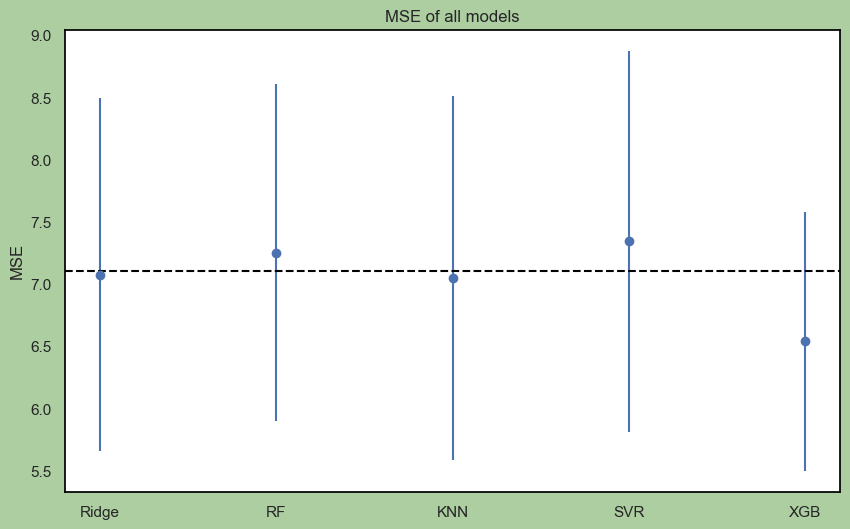

In [105]:
# plot errorbar of all model scores
plt.figure(figsize=(10, 6))
plt.errorbar([1, 2, 3, 4, 5], [-np.mean(en_scores), -np.mean(rf_scores), -np.mean(knn_scores), -np.mean(svr_scores), -np.mean(xgb_scores)],
                yerr=[np.std(en_scores), np.std(rf_scores), np.std(knn_scores), np.std(svr_scores), np.std(xgb_scores)], fmt='o')
plt.xticks([1, 2, 3, 4, 5], ['Ridge', 'RF', 'KNN', 'SVR', 'XGB'])
plt.ylabel('MSE')
plt.title('MSE of all models')
plt.axhline(y=baseline_mse, color='black', linestyle='--')
plt.gca().set_facecolor('white')
# set background color to be white
ax = plt.gca()
ax.set_facecolor('white')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
plt.savefig('../images/mse.png', dpi=300)

plt.show()





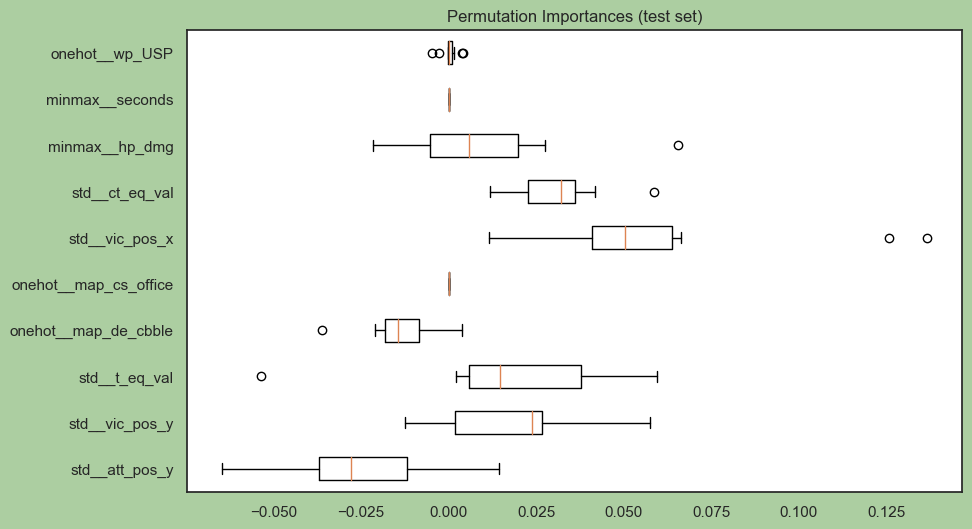

In [115]:
best_model = xgb_models[np.argmax(xgb_scores)]
from sklearn.inspection import permutation_importance
# get feature names from clf
feature_names = clf.get_feature_names_out()
result = permutation_importance(best_model, xgb_X_tests[np.argmax(xgb_scores)], xgb_y_tests[np.argmax(xgb_scores)], n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()[::-1][:10] - 1
plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.gca().set_facecolor('white')
plt.savefig('../images/feature_importance.png', dpi=300)
plt.show()

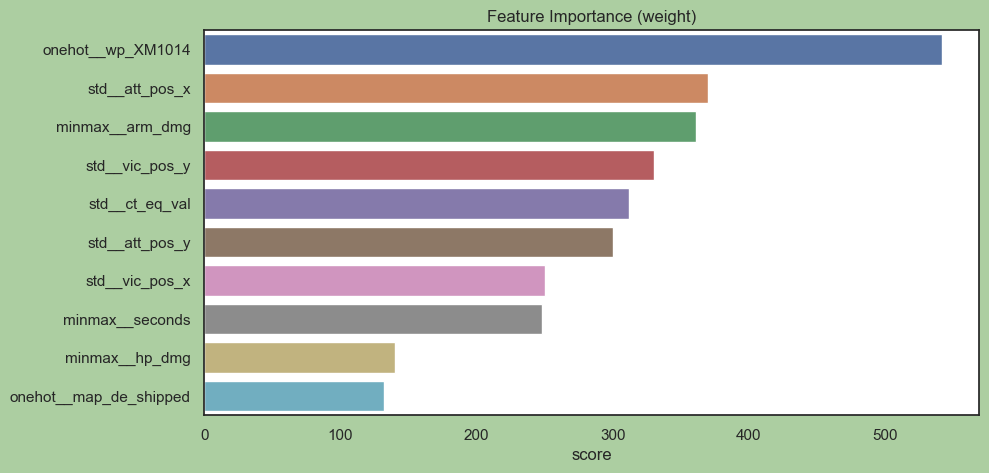

In [122]:
importance_types = ['weight','gain','cover','total_gain','total_cover']
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
i = 0
type = importance_types[i]
importance  = best_model.get_booster().get_score(importance_type=type)
top10 = sorted(importance, key=lambda x:importance[x], reverse=True)[:10]
top10_idx = [int(i[1:])-2 for i in top10]
top10_names = feature_names[top10_idx]
# plot the top10 using seaborn barplot
sns.barplot(x=[importance[x] for x in top10], y=top10)
plt.yticks(range(len(top10)), top10_names)
plt.title("Feature Importance ("+type+")")
plt.gca().set_facecolor('white')
plt.xlabel("score")
plt.savefig('../images/feature_importance_'+type+'1.png', dpi=300)

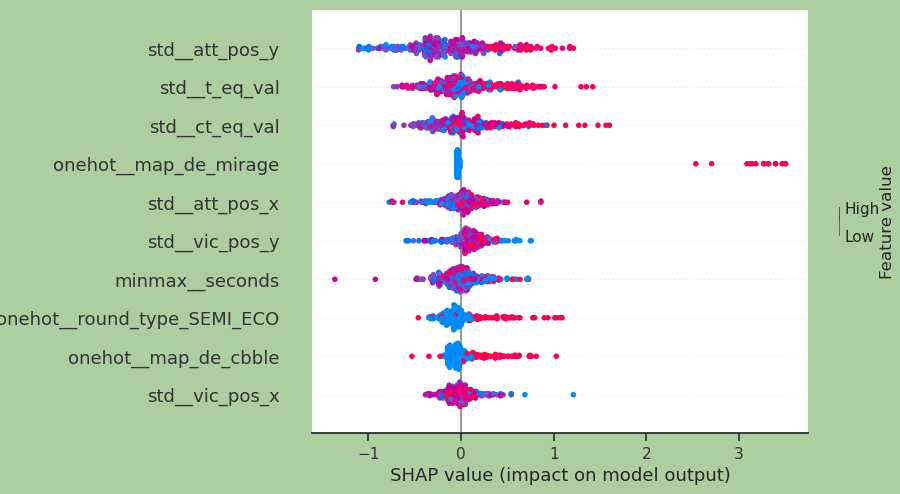

In [148]:
import shap
shap.initjs()
# shap explainer for xgb regression
x_test, y_test = xgb_X_tests[np.argmax(xgb_scores)], xgb_y_tests[np.argmax(xgb_scores)]
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, feature_names=feature_names, max_display=10, show=False)
plt.savefig('../images/shap.png', dpi=500)
plt.gca().set_facecolor('white')
plt.rcdefaults()
plt.show()


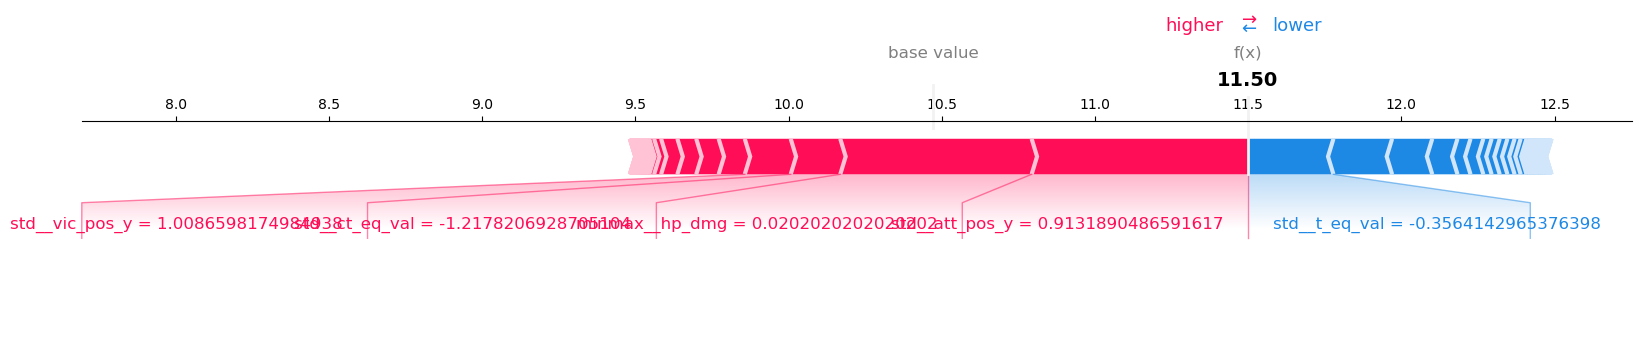

In [149]:
df_test = pd.DataFrame(x_test, columns=feature_names)
shap_i = 200
shap.force_plot(explainer.expected_value, shap_values[shap_i,:], df_test.iloc[shap_i,:], matplotlib=True, show=False)
plt.savefig('../images/shap_force.png', dpi=300)
plt.rcdefaults()
plt.gca().set_facecolor('white')
plt.show()


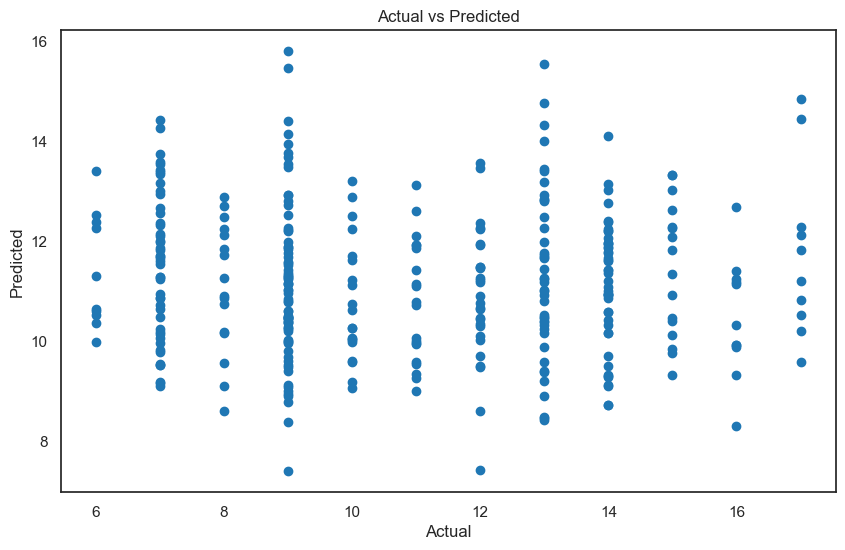

In [150]:
df_test['y_test'] = xgb_y_tests[np.argmax(xgb_scores)].reset_index(drop=True)
df_test['y_pred'] = best_model.predict(x_test)
# plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(df_test['y_test'], df_test['y_pred'])
# plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c=".3")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.gca().set_facecolor('white')
plt.savefig('../images/actual_vs_predicted.png', dpi=300)
plt.show()
